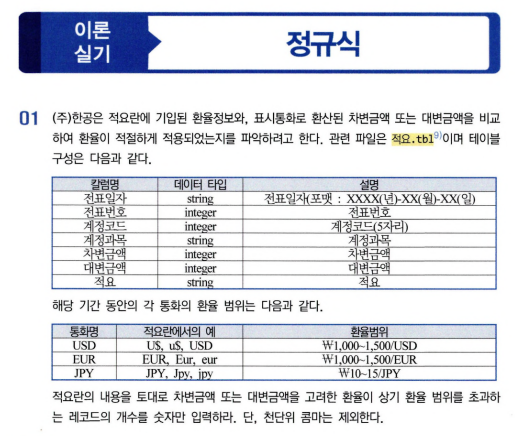

In [4]:
import re

# ------------------------------------------------------------
# 1) 정규식: 통화가 앞/뒤 모두 가능한 패턴을 한 번에 처리
#    - 앞:  USD 1,000.50 / US$1,000 / eur 500 / jpy 10,000
#    - 뒤:  1,000/USD  /  500 eur  (슬래시나 공백으로 연결)
#    - 대소문자 무시, US$ 허용
# ------------------------------------------------------------
CUR = r'(USD|US\$|EUR|JPY)'
AMT = r'(\d{1,3}(?:[.,]\d{3})*(?:[.,]\d+)?|\d+(?:[.,]\d+)?)'  # 1,234.56 / 1234,56 / 1234

pattern = re.compile(
    rf'(?:\b(?P<cur1>{CUR})\s*?(?P<amt1>{AMT})\b)|'      # 통화가 앞: USD 1,000.50
    rf'(?:\b(?P<amt2>{AMT})\s*[/ ]\s*(?P<cur2>{CUR})\b)',# 통화가 뒤: 1,000 / USD
    flags=re.IGNORECASE
)

def normalize_amount_str(s: str) -> float:
    """
    문자열 금액을 float으로 변환.
    - '1,234.56' → 1234.56
    - '1.234,56' → 1234.56 (콤마를 소수점으로 간주)
    - '1234'     → 1234.0
    규칙:
      1) '.'과 ','가 둘 다 있으면: ','를 소수점, '.'는 천단위로 간주
      2) 하나만 있으면: 그 하나를 소수점으로 본다고 가정 (유럽식/미국식 혼용 최소 대응)
    """
    s = s.strip()
    if not s:
        return 0.0

    if '.' in s and ',' in s:
        # 예: '1.234,56' → '1234.56'
        s = s.replace('.', '').replace(',', '.')
    else:
        # 하나만 있거나 없음 → 천단위 구분자를 제거하고 소수점은 유지
        # (천단위로 쓰였을 가능성이 큰 기호를 제거)
        s = s.replace(',', '')

    try:
        return float(s)
    except ValueError:
        return 0.0

# ----------------------------------------------------------------
# 2) 본문 처리
#   descriptions: 각 원소가 dict인 리스트를 가정
#   예시:
#   descriptions = [
#       {"description": "USD 1,000.50 호텔 결제", "debit_amount": 1300000, "credit_amount": 0},
#       {"description": "1,000 / USD 카드 승인",   "debit_amount": 0,        "credit_amount": 1300000},
#       {"description": "EUR500.25 항공",         "debit_amount": 0,        "credit_amount": 0},
#   ]
# ----------------------------------------------------------------

for row in descriptions:
    text = row.get('description', '')

    m = pattern.search(text)
    if m:
        # 통화/금액이 앞에 있던 케이스(cur1, amt1) 또는 뒤에 있던 케이스(amt2, cur2) 중 매칭된 쪽 사용
        cur = (m.group('cur1') or m.group('cur2') or '').upper().replace('US$', 'USD')
        amt_str = (m.group('amt1') or m.group('amt2') or '')
        amt = normalize_amount_str(amt_str)
    else:
        cur, amt = '0', 0.0

    row['currency_code'] = cur            # 통화코드 (USD/EUR/JPY 또는 '0')
    row['foreign_amount'] = amt           # 외화금액 (float)

# ------------------------------------------------------------
# 3) 환율 계산
#   - debit만 있으면:  환율 = |debit| / foreign_amount
#   - credit만 있으면: 환율 = |credit| / foreign_amount
#   - 둘 다 0이면 0
#   - foreign_amount == 0이면 0
# ------------------------------------------------------------
for row in descriptions:
    debit  = row.get('debit_amount', 0) or 0
    credit = row.get('credit_amount', 0) or 0
    f_amt  = float(row.get('foreign_amount', 0) or 0)

    if debit == 0 and credit == 0:
        rate = 0.0
    elif debit != 0 and credit == 0:
        rate = abs(debit) / f_amt if f_amt else 0.0
    elif debit == 0 and credit != 0:
        rate = abs(credit) / f_amt if f_amt else 0.0
    else:
        # 둘 다 값이 있으면 케이스에 따라 정책 정해야 함. 여기선 0 처리.
        rate = 0.0

    row['exchange_rate'] = rate

# 결과 확인
print(descriptions)


NameError: name 'descriptions' is not defined